In [1]:
import os
import numpy as np 
import surveysim.stats
from astropy.io import fits
from astropy.time import Time

# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
_dir = '/global/cscratch1/sd/chahah/desisurvey_output'

In [3]:
texp = 140
footprint = 13000
twilight = False
_file = '%is_bgs%i_skybranch_v4%s.brightsky.bgs%i' % (texp, footprint, ['', '.twilight'][twilight], footprint)

fstats = os.path.join(_dir, 'stats_%s.fits' % _file)
stats = surveysim.stats.SurveyStatistics(restore=fstats, bgs_footprint=footprint)

fexps = os.path.join(_dir, 'exposures_%s.fits' % _file)
exps = fits.getdata(fexps, 'exposures')

  404 of 6028 BRIGHT tiles removed for reduced footprint
  ~13061.712011 sq.deg
(15667,)
INFO:stats.py:79:__init__: Restored stats from /global/cscratch1/sd/chahah/desisurvey_output/stats_140s_bgs13000_skybranch_v4.brightsky.bgs13000.fits
INFO:stats.py:81:__init__:   Comment: "".


In [4]:
stats.summarize()

Scheduled 12788.664 hr Open 74.761% Live 55.161%
PROG PASS    TILES  NEXP SETUP ABT SPLIT ABT    TEXP TSETUP TSPLIT   TOPEN  TDEAD
DARK   0 2010/2010  6254  2645   6  3609  14 1373.2s 158.1s 107.9s
DARK   1 2011/2011  6311  2532   3  3779  11 1359.1s 151.1s 112.9s
DARK   2 2007/2007  6639  2608   8  4031   5 1437.0s 156.2s 120.6s
DARK   3 2010/2010  6618  2577   9  4041   9 1413.4s 154.1s 120.7s
DARK     8038/8038 25822 10362  26 15460  39 1395.7s 154.9s 115.5s 2775.6s 1109.5s
----------------------------------------------------------------------------------
GRAY   4 1637/2005  9756  2885  16  6871  11 3030.0s 212.0s 252.0s
GRAY     1637/2005  9756  2885  16  6871  11 3030.0s 212.0s 252.0s 3495.2s   1.0s
----------------------------------------------------------------------------------
BRIGHT 5 1873/1873  4022  2041   7  1981   5  478.8s 131.0s  63.5s
BRIGHT 6 1875/1875  4272  2180   6  2092   6  510.5s 139.8s  67.0s
BRIGHT 7 1876/1876  4239  2066  10  2173   2  508.3s 132.5s  69.5s
BR

In [5]:
actual = np.cumsum(stats._data['completed'], axis=0)

third_pass = stats.tiles.program_passes['BRIGHT'][-1]
npass = stats.tiles.pass_ntiles[third_pass]
passidx = stats.tiles.pass_index[third_pass]
bgs_complete = (actual[:,passidx] / npass) == 1.

dt = 1 + np.arange(len(stats._data))
print('BGS finishes 3rd passs on day %i of %i' % (dt[bgs_complete].min(), dt[-1]))
print('  %.1f percent margin' % (100.*(dt[-1] - dt[bgs_complete].min())/dt[-1]))

BGS finishes 3rd passs on day 1481 of 1826
  18.9 percent margin


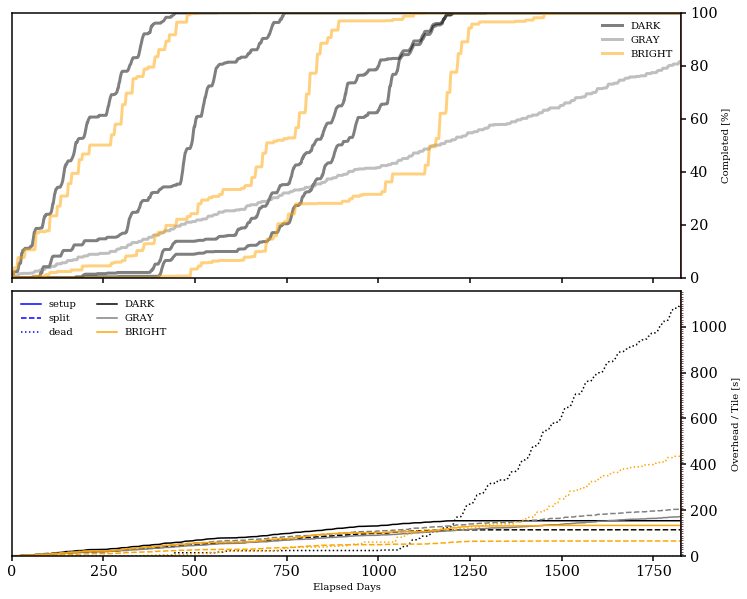

In [6]:
fig, sub = stats.plot()

In [7]:
actual = np.cumsum(stats._data['completed'], axis=0)

In [8]:
third_pass = stats.tiles.program_passes['BRIGHT'][-1]
npass = stats.tiles.pass_ntiles[third_pass]
passidx = stats.tiles.pass_index[third_pass]
bgs_complete = (actual[:,passidx] / npass) == 1.

dt = 1 + np.arange(len(stats._data))
print('BGS finishes 3rd passs on day %i of %i' % (dt[bgs_complete].min(), dt[-1]))
print('  %.1f percent margin' % (100.*(dt[-1] - dt[bgs_complete].min())/dt[-1]))

BGS finishes 3rd passs on day 1481 of 1826
  18.9 percent margin


In [9]:
# get BGS tiles
_pass = np.zeros(len(stats.tiles.passnum)).astype(bool)
for i in range(3):
    _pass = _pass | (stats.tiles.passnum == stats.tiles.program_passes['BRIGHT'][i-3])
    
tileid_pass = stats.tiles.tileID[_pass]
_, m0, m1 = np.intersect1d(exps['TILEID'], tileid_pass, return_indices=True)

Text(0.5, 0, 'RA')

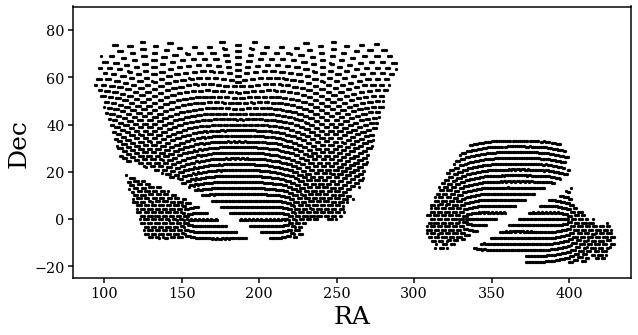

In [10]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

sub.scatter(((stats.tiles.tileRA[_pass] - 80) % 360) + 80, stats.tiles.tileDEC[_pass], s=5, c='k')
sub.set_xlim(80, 440)
sub.set_ylabel('Dec', fontsize=25)
sub.set_ylim(-25., 90.)
sub.set_xlabel('RA', fontsize=25)

In [11]:
t_exps = Time(exps['MJD'], format='mjd')

Text(0.5, 0, 'RA')

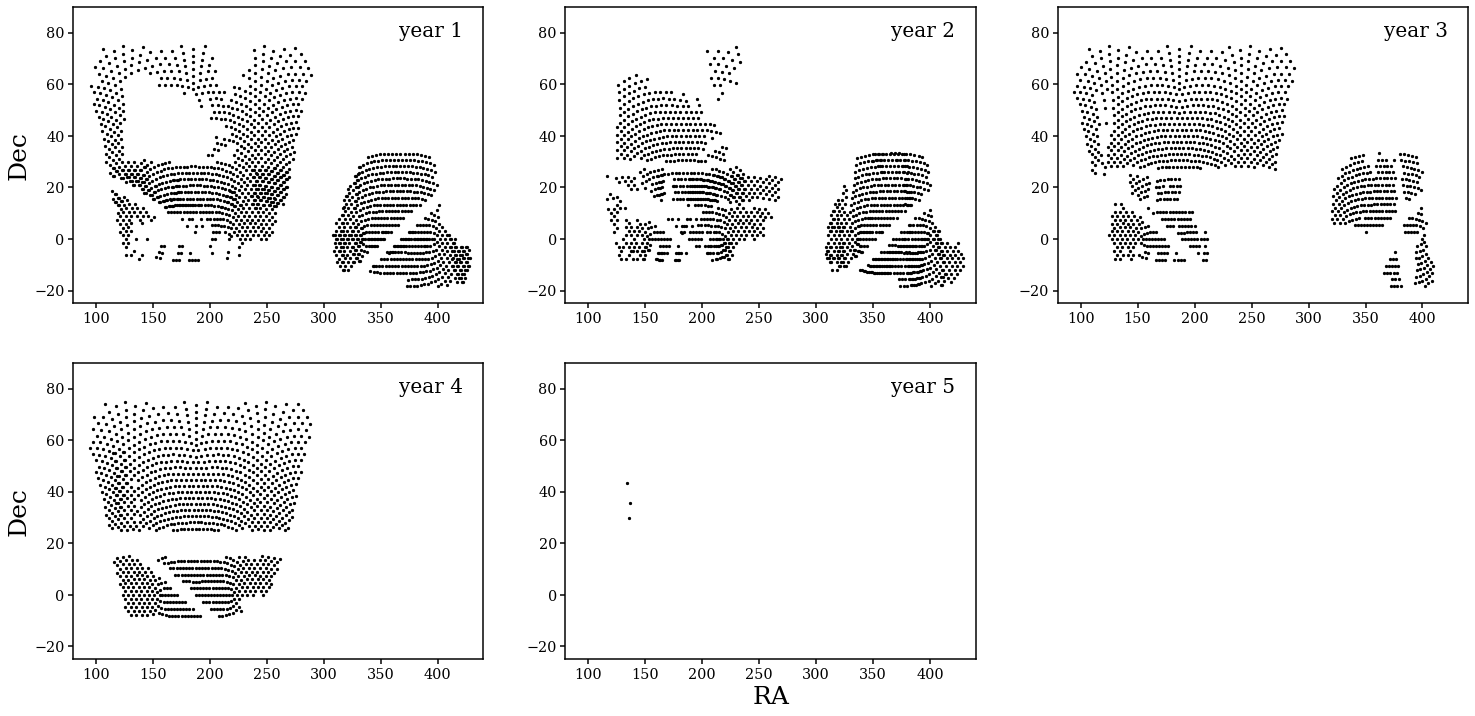

In [12]:
fig = plt.figure(figsize=(25, 12))
for year in range(5): 
    inyear = (t_exps[m0].decimalyear >= t_exps.decimalyear.min() + year) & (t_exps[m0].decimalyear < t_exps.decimalyear.min() + year + 1)
    
    sub = fig.add_subplot(2,3,year+1)
    sub.scatter(((stats.tiles.tileRA[_pass][m1][inyear] - 80) % 360) + 80, stats.tiles.tileDEC[_pass][m1][inyear], s=5, c='k')
    sub.set_xlim(80, 440)
    if year in [0, 3]: sub.set_ylabel('Dec', fontsize=25)
    sub.set_ylim(-25., 90.)
    sub.text(0.95, 0.95, 'year %i' % (year+1), transform=sub.transAxes, ha='right', va='top', fontsize=20)
sub.set_xlabel('RA', fontsize=25)